<a href="https://colab.research.google.com/github/Jieoi/traffic_sign_recognition/blob/main/test_data_preparation_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: This instance of Google Colab has been configured to use the standard CPU.

Note: The code below has been configured to run on Google colab with python scripts imported from google drive. Please download the scripts from [here](https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8). Files required including all scripts and helper files under data_preparation folder and data_augmentation folder. Alternatively, vist my github repository to [download](https://github.com/Jieoi/traffic_sign_recognition/tree/main) the scripts and helper files.

<h2>3. Preparation of testing data using simple filters</h2>

Some libraries are used in this notebook

In [3]:
# Sytem handling
import os
import shutil
import sys

# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Image handling
import cv2

# Zip files handling
import zipfile

Similar to there colab instances, mount Google Drive to access the data stored in Google Drive.

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('drive', force_remount=True)

Mounted at drive


<h2>3.1 Data extraction</h2>

As the getFile.py and getData.py were already tested in section 1 when extracting training data, they will be directly imported here.

In [4]:
# Define the path to the getFile.py script
script_path = 'drive/MyDrive/final/data_preparation/getFile.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

Extract the data from the zip file using getFile.py

In [5]:
# Import the extract_zip_to_directory function from getFile.py
from getFile import extract_zip_to_directory

# Define file paths
root_path = 'drive/MyDrive'
zip_filename = os.path.join(root_path, 'GTSRB/GTSRB.zip')
extract_dir = "GTSRB"

# Call the function
extract_zip_to_directory(zip_filename, extract_dir)

Extraction complete.



Test data and their corresponding labels (ground truth) where obtained from the folders using the getData.py


In [6]:
# Assign the paths
ground_truth = os.path.join(extract_dir, 'GTSRB', 'GTSRB_Final_Test_GT', 'GT-final_test.csv')
test_directory = os.path.join(extract_dir, 'GTSRB', 'GTSRB_Final_Test_Images', 'GTSRB', 'Final_Test', 'Images')

print("ground_truth:", ground_truth)
print("test_directory:", test_directory)

ground_truth: GTSRB/GTSRB/GTSRB_Final_Test_GT/GT-final_test.csv
test_directory: GTSRB/GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images


In [7]:
# Define the path to the getFile.py script
script_path = 'drive/MyDrive/final/data_preparation/getData.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

import getData

In [8]:
images = getData.load_testing_images(test_directory)
labels = getData.load_ground_truth(ground_truth)

Skipping file: GTSRB/GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/GT-final_test.test.csv
Loaded 12630 test images in 0.8461687564849854 seconds.


<h2> 3.2 Simple statictics</h2>

The shape of images are checked and the labels(class ID) are displayed

In [17]:
images.shape

(12630, 32, 32, 3)

In [18]:
labels["ClassId"]

0        16
1         1
2        38
3        33
4        11
         ..
12625    12
12626    33
12627     6
12628     7
12629    10
Name: ClassId, Length: 12630, dtype: int64

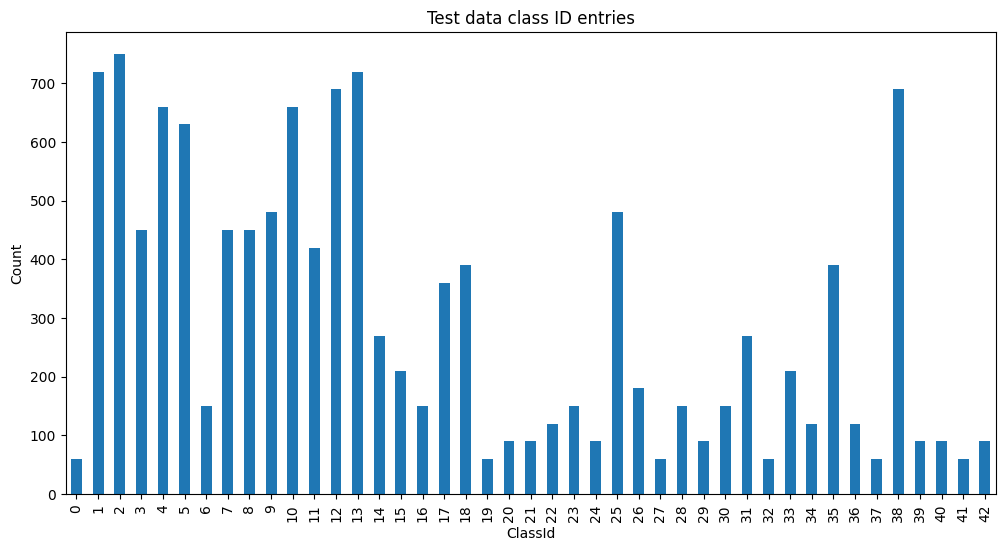

In [19]:
class_counts = labels["ClassId"].value_counts().sort_index()

# Create a bar graph
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title("Test data class ID entries")
plt.xlabel("ClassId")
plt.ylabel("Count")
plt.show()

From the graph above, it was noted that the distribution of the test data is imbalanced. However, the data distribution (shape) is **similar to the original training data.**

Thus, the decision is to use this data for the testing **without any data augmentation**. However, **data enhancement technices will still be used**.

<h2> 3.3 Data Processing </h2>

Similar to that of the training data, the data processing is done using the processing_image.py. Bicubic interpolation upscaling, histogram equalization and denoising will be used.

In [9]:
# Define the path to the processing_image.py script
script_path = 'drive/MyDrive/final/data_augmentation/processing_image.py'

# Add the script directory to sys.path to import the module
script_dir = os.path.dirname(script_path)
sys.path.append(script_dir)

import processing_image

In [ ]:
# surpress heartbeat stdout by the denoising function
%%capture
# Import the upscale_images function
# Call the upscale_images function
upscale_factor = 3
upscaled_images = processing_image.upscale_images(images, upscale_factor)

# Call the equalize_images function
equalized_images = processing_image.equalize_images(upscaled_images)

# Call the laplacian_smoothing function with the converted images
denoised_images = processing_image.denoise_images_parallel(equalized_images)

In [ ]:
denoised_images.shape

(12630, 96, 96, 3)

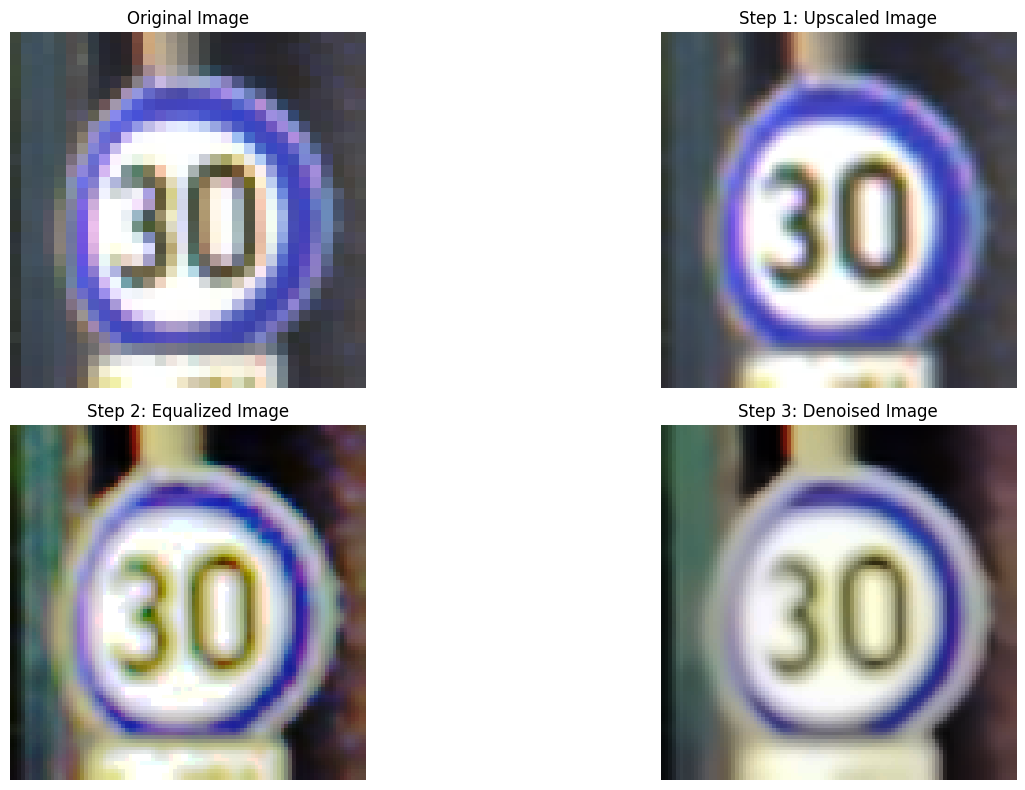

In [ ]:
# Display the original image, upscaled image, equalized image, denoised image, and smoothed image
plt.figure(figsize=(16, 8))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(images[1])
plt.title("Original Image")
plt.axis("off")

# Upscaled Image
plt.subplot(2, 2, 2)
plt.imshow(upscaled_images[1])
plt.title("Step 1: Upscaled Image")
plt.axis("off")

# Equalized Image
plt.subplot(2, 2, 3)
plt.imshow(equalized_images[1])
plt.title("Step 2: Equalized Image")
plt.axis("off")

# Denoised Image
plt.subplot(2, 2, 4)
plt.imshow(denoised_images[1])
plt.title("Step 3: Denoised Image")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Calculate the standard deviation of pixel values
std_dev_old = np.std(images[0])
std_dev_processed = np.std(denoised_images[0])

# Calculate the median absolute deviation (MAD) of pixel values
median_abs_dev_old = np.median(np.abs(images[0] - np.median(images[0])))
median_abs_dev_processed = np.median(np.abs(denoised_images[0] - np.median(denoised_images[0])))

print(f"Standard Deviation (Noise Level before processing): {std_dev_old}")
print(f"Median Absolute Deviation (Noise Level before processing): {median_abs_dev_old}")
print(f"Standard Deviation (Noise Level after processing): {std_dev_processed}")
print(f"Median Absolute Deviation (Noise Level after processing): {median_abs_dev_processed}")

Standard Deviation (Noise Level before processing): 0.18486033380031586
Median Absolute Deviation (Noise Level before processing): 0.11372551321983337
Standard Deviation (Noise Level after processing): 73.33396935919428
Median Absolute Deviation (Noise Level after processing): 64.0


<h2>3.4 Data saving</h2>

In [24]:
# Define the folder path to save the images
save_folder = "enhanced_images"
os.makedirs(save_folder, exist_ok=True)

# Initialize lists to store filenames and class labels
filenames = []
classes = []

# Save augmented images to the folder
for i, image in enumerate(denoised_images):
    class_label = labels["ClassId"].iloc[i]
    filename = f"{class_label}_{i}.png"
    file_path = os.path.join(save_folder, filename)
    cv2.imwrite(file_path, image)

    # Append filename and class to the lists
    filenames.append(filename)
    classes.append(class_label)

In [ ]:
# Create a DataFrame to store the data
data = {"filename": filenames, "class": classes}
df = pd.DataFrame(data)

# Save the DataFrame as a CSV file
csv_file_path = "labels.csv"
df.to_csv(csv_file_path, index=False)

print("CSV file 'labels.csv' has been saved at:", csv_file_path)

CSV file 'labels.csv' has been saved at: /content/labels.csv


In [ ]:
df.head()

,filename,class
0,16_0.png,16
1,1_1.png,1
2,38_2.png,38
3,33_3.png,33
4,11_4.png,11


In [ ]:
# Specify the directory path
folder_path = 'enhanced_images'

# List all files in the directory
file_list = os.listdir(folder_path)

# Count the number of files
num_files = len(file_list)

print(f"Number of files in the folder: {num_files}")

Number of files in the folder: 12630


In [ ]:
shutil.make_archive('enhanced_images', 'zip', save_folder)

# Move the zip file to Google Drive
zip_path = 'enhanced_images.zip'
drive_save_path = '/content/drive/MyDrive/final/test_data/test_image_simple.zip'
shutil.move(zip_path, drive_save_path)

'/content/drive/MyDrive/final/test_data/test_image_simple.zip'

In [ ]:
# Define the source CSV file path
source_csv_path = csv_file_path

# Define the destination folder in your Google Drive
destination_folder = "/content/drive/MyDrive/final/test_data"

# Define the new filename for the CSV file
new_csv_filename = "test_image_simple.csv"

# Move the CSV file to your Google Drive and rename it
shutil.move(source_csv_path, os.path.join(destination_folder, new_csv_filename))

'/content/drive/MyDrive/final/test_data/test_image_simple.csv'